# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
from pandas import Series
from pandas.plotting import lag_plot

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import max_error
from sklearn.metrics import r2_score

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from numpy.random import seed

import math
from math import sqrt

from matplotlib import pyplot
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import warnings
warnings.filterwarnings("ignore")

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

# Loading dataset

In [2]:
# flight_4 = pd.read_csv("Combined_Data_Apr21.csv")
# flight_5 = pd.read_csv("Combined_Data_May21.csv")
# flight_6 = pd.read_csv("Combined_Data_Jun21.csv")
# flight_4 = flight_4.append(flight_5)
# flight_4 = flight_4.append(flight_6)

In [3]:
flight_4 = pd.read_csv("Combined_Data_All.csv")
light = flight_4[["Timestamp", "Num_Flights", "Num_Covid_Cases"]]

In [4]:
flight_4

,Timestamp,Country,Num_Flights,Num_Covid_Cases
0,2020-01-22,Algeria,38,0.0
1,2020-01-22,Antigua and Barbuda,5,0.0
2,2020-01-22,Argentina,17,0.0
3,2020-01-22,Australia,208,0.0
4,2020-01-22,Austria,116,0.0
...,...,...,...,...
44247,2022-01-31,Ukraine,4,23063.0
44248,2022-01-31,United Arab Emirates,32,2028.0
44249,2022-01-31,United Kingdom,54,848962.0
44250,2022-01-31,United States,4736,527140.0


In [5]:
data = light.groupby(by=["Timestamp"]).sum()
data.reset_index()
data

,Num_Flights,Num_Covid_Cases
Timestamp,,
2020-01-22,7545,655.0
2020-01-23,8979,98.0
2020-01-24,9124,286.0
2020-01-25,7654,492.0
2020-01-26,6751,684.0
...,...,...
2022-01-27,8174,3122335.0
2022-01-28,8376,3138982.0
2022-01-29,6924,2146044.0


# Visualizing train data

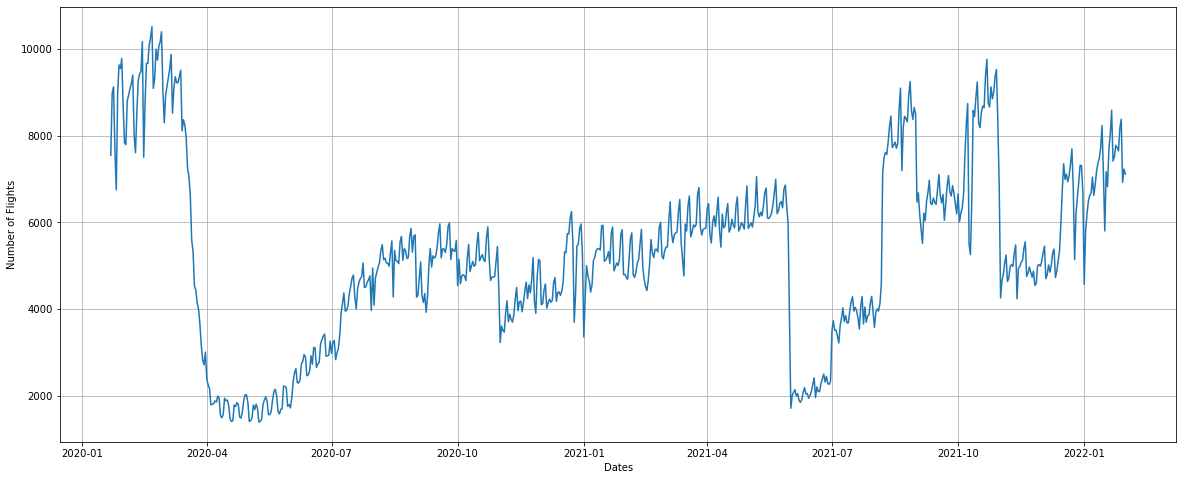

In [6]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('data.csv', sep=',', parse_dates=['Timestamp'], index_col='Timestamp',date_parser=dateparse)
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Number of Flights')
plt.plot(data['Num_Flights']);
plt.show()

# Plotting autocorrelation

No handles with labels found to put in legend.


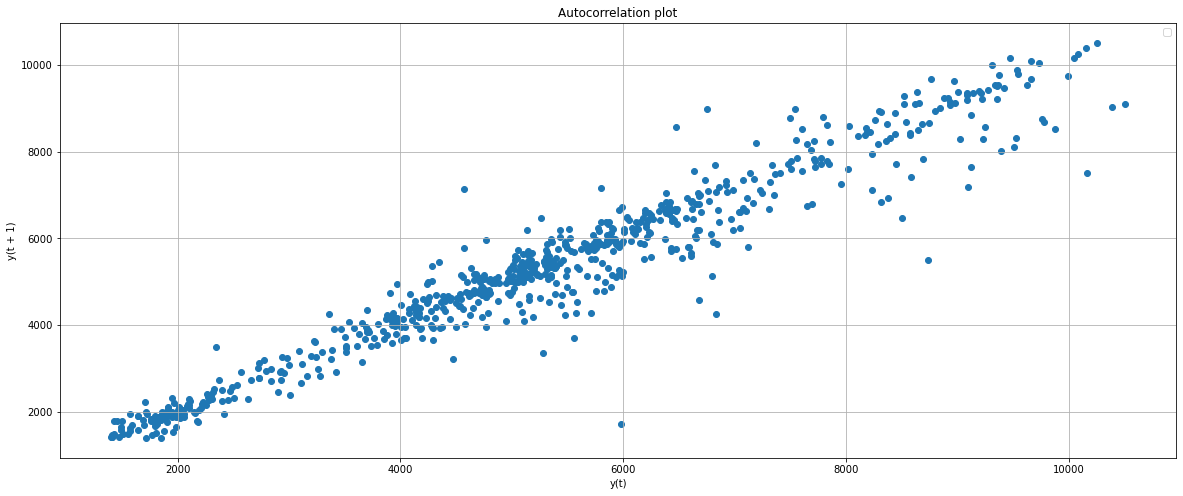

In [7]:
plt.figure(figsize=(20,8))
lag_plot(data['Num_Flights'], lag=1)
plt.title('Autocorrelation plot')
plt.grid(True)
plt.legend();

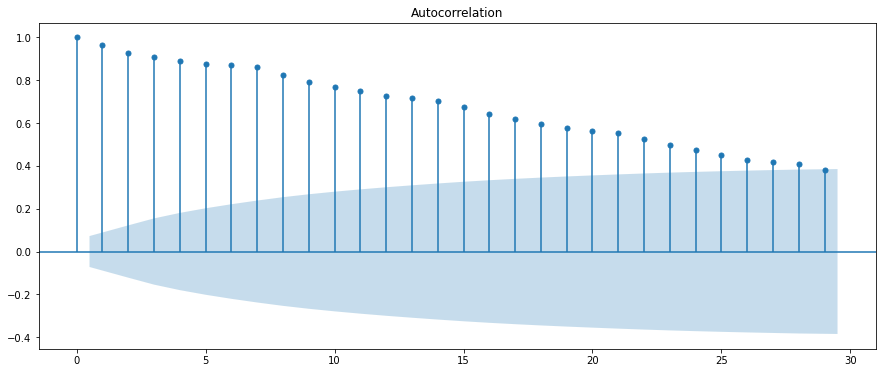

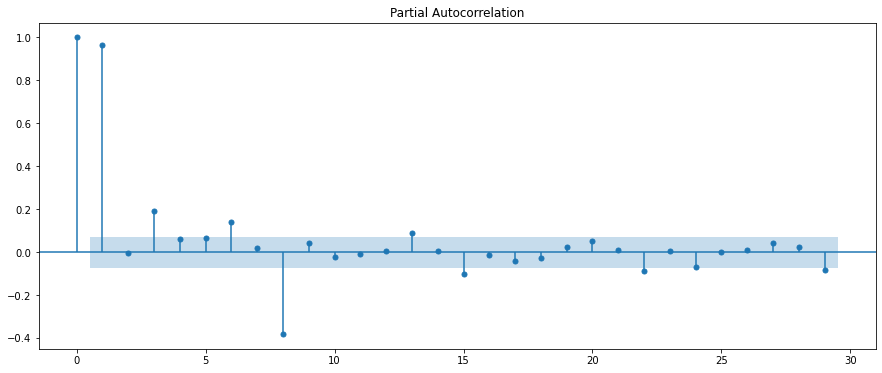

In [8]:
fig1=plot_acf(data['Num_Flights'].dropna()) 
fig2=plot_pacf(data['Num_Flights'].dropna()) 

In [9]:
values = DataFrame(data['Num_Flights'].values)
dataframe = concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000 -0.224504
t+1 -0.224504  1.000000


In [10]:
data.tail()

,Num_Flights,Num_Covid_Cases
Timestamp,,
2022-01-27,8174,3122335.0
2022-01-28,8376,3138982.0
2022-01-29,6924,2146044.0
2022-01-30,7230,1842602.0
2022-01-31,7112,3197167.0


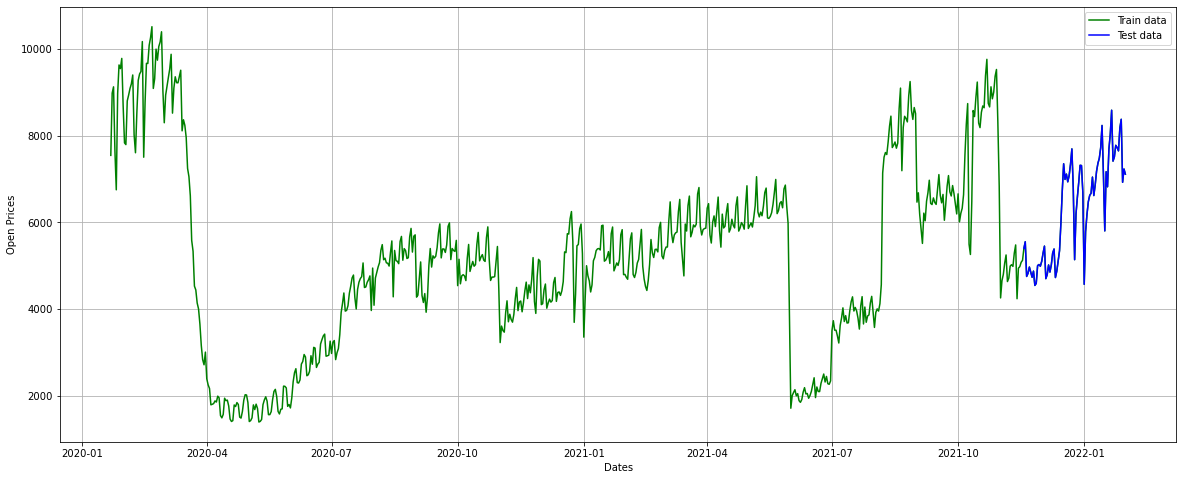

In [11]:
train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Num_Flights'], 'green', label='Train data')
plt.plot(test_data['Num_Flights'], 'blue', label='Test data')
plt.legend()

In [12]:
train = train_data.iloc[:, 0:1].values

# Feature Scaling

In [13]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train) 

In [14]:
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
seed(2019)

# Building the RNN

In [16]:
model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Dropout regularisation for tackling overfitting
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN

In [17]:
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set

In [18]:
history = model.fit(X_train, y_train, epochs = 60, batch_size = 25)
history

Epoch 1/60
27/27 [==============================] - 5s 12ms/step - loss: 0.0634
Epoch 2/60
27/27 [==============================] - 0s 12ms/step - loss: 0.0133
Epoch 3/60
27/27 [==============================] - 0s 12ms/step - loss: 0.0112
Epoch 4/60
27/27 [==============================] - 0s 12ms/step - loss: 0.0111
Epoch 5/60
27/27 [==============================] - 0s 13ms/step - loss: 0.0120
Epoch 6/60
27/27 [==============================] - 0s 12ms/step - loss: 0.0117
Epoch 7/60
27/27 [==============================] - 0s 13ms/step - loss: 0.0105
Epoch 8/60
27/27 [==============================] - 0s 13ms/step - loss: 0.0102
Epoch 9/60
27/27 [==============================] - 0s 12ms/step - loss: 0.0115
Epoch 10/60
27/27 [==============================] - 0s 12ms/step - loss: 0.0110
Epoch 11/60
27/27 [==============================] - 0s 12ms/step - loss: 0.0106
Epoch 12/60
27/27 [==============================] - 0s 12ms/step - loss: 0.0122
Epoch 13/60
27/27 [==================

# Loss Function

Train: 0.003, Test: 0.003


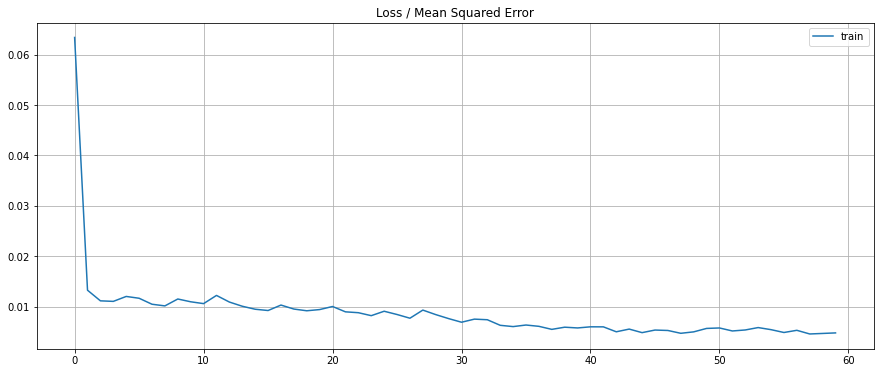

In [19]:
# evaluate the model
train_mse = model.evaluate(X_train, y_train, verbose=0)
test_mse = model.evaluate(X_train, y_train, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
# plot loss during training
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.grid(True)
pyplot.show()

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_2 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               8

# Prediction

In [21]:
# Now making the predictions and visualising the results
# this will be used later while comparing and visualization
real = test_data.iloc[:,0:1].values

In [22]:
combine = pd.concat((train_data['Num_Flights'], test_data['Num_Flights']), axis = 0)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [23]:
test_data.shape

(74, 2)

In [24]:
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted = model.predict(X_test)

# inverse_transform because prediction is done on scaled inputs
predicted = scaler.inverse_transform(predicted)

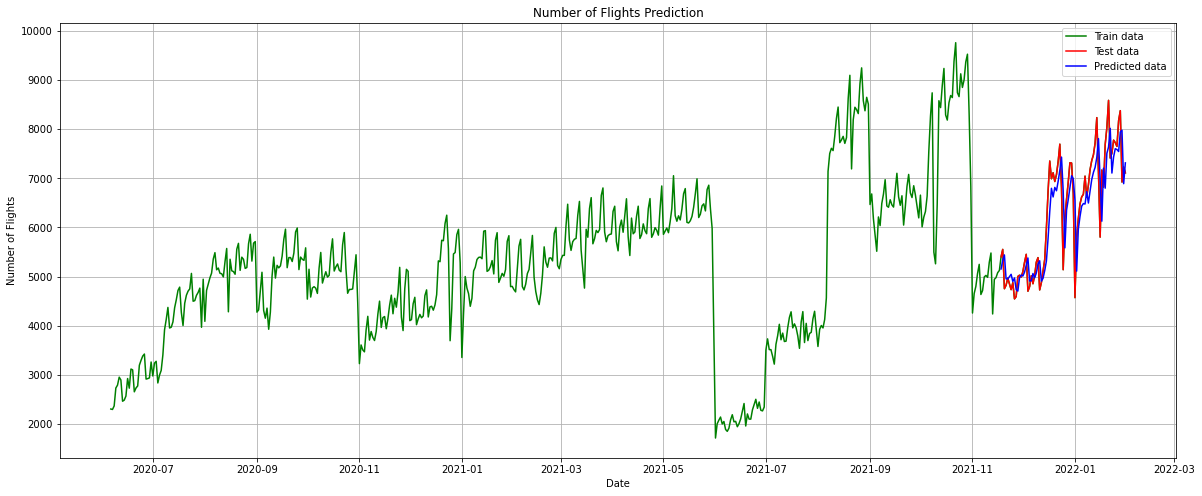

In [25]:
plt.figure(figsize=(20,8))
plt.plot(data.index[-600:], data['Num_Flights'].tail(600), color='green', label = 'Train data')
plt.plot(test_data.index, real, color = 'red', label = 'Test data')
plt.plot(test_data.index, predicted, color = 'blue', label = 'Predicted data')
plt.title('Number of Flights Prediction')
plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.legend()
plt.grid(True)
plt.savefig('lstm_30.pdf')
plt.show()

# Performance and Evaluation

In [26]:
mse = mean_squared_error(real, predicted)
print('MSE: '+str(mse))
mae = mean_absolute_error(real, predicted)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real, predicted))
print('RMSE: '+str(rmse))
me = max_error(test_data['Num_Flights'], predicted)
print('ME: '+str(me))
score = r2_score(test_data['Num_Flights'], predicted)
print('r2 score: '+str(score))
result = adfuller(data['Num_Flights'])
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],result))

MSE: 313407.58241412445
MAE: 427.68396326013516
RMSE: 559.8281722226244
ME: 1982.78466796875
r2 score: 0.7680729291055426


{'adf': -3.370796136929915,
 'pvalue': 0.011995641459335758,
 'usedlag': 7,
 'nobs': 728,
 'criticalvalues': {'1%': -3.4393644334758475,
  '5%': -2.8655182850048306,
  '10%': -2.568888486973192},
 'icbest': 10854.481785233713}

In [27]:
lstm_df = pd.DataFrame(predicted)
lstm_df.to_csv('lstm_predictions.csv')